# Livable Streets: Bike Infrastructure & Displacement
## Project Deliverable 1

#### Siddharth Bookinkere, Alexander Heger, Kwan Wing Tuet, Raviv Zait

## Clone repository

In [22]:
!git clone https://github.com/BU-Spark/ds-livable-streets-infra.git

fatal: destination path 'ds-livable-streets-infra' already exists and is not an empty directory.


## Collect and Pre-process Census and Bike Data

### Read data

In [17]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Set the current working directory to the root of the repository
# os.chdir("C:/Users/Alex H/OneDrive/Documents/BU Fall 2023/DS701/ds-livable-streets-infra/")
os.chdir(r"C:\Users\Raviv\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Python 3.10\ds-livable-streets-infra")
# Customize data folder
data_folder = "fa23-team/data/"

# Read demographic and property value data
combined_demo_prop = pd.read_csv(data_folder + "combined_demo_prop.csv", index_col=False)
print("Demographic and property value data shape: ", combined_demo_prop.shape)

# Read income and house ownership data
combined_income_owner = pd.read_csv(data_folder+"income_houseownership.csv", index_col=False)
print("Income and house ownership data shape: ",combined_income_owner.shape)

# Read bike infrastructure data
bike_file_path = data_folder + '/Existing_Bike_Network_2023.geojson'
bike_lanes = gpd.read_file(bike_file_path)
print("Bike infrastructure shape: ", bike_lanes.shape)

bike_data = pd.read_csv(data_folder + "bike_combined_data_8-11.csv", index_col=False)
print("Bike aggregated data shape: ", bike_data.shape)

tracts_2010_file_path = data_folder + 'Census_2010_Tracts.geojson' #https://data.boston.gov/dataset/census-2010-tracts
tracts_2010 = gpd.read_file(tracts_2010_file_path)
print("Tracts 2010 shape: ", tracts_2010.shape)

Demographic and property value data shape:  (564, 16)
Income and house ownership data shape:  (606, 17)
Bike infrastructure shape:  (3243, 11)
Bike aggregated data shape:  (720, 13)
Tracts 2010 shape:  (181, 19)


### Clean Income and House Ownership Data

In [19]:
# Drop diff columns
combined_income_owner.drop(["median_income_difference", "mean_income_difference"], axis=1,
                           inplace=True)

# Rename columns
combined_income_owner.columns = ["year", "median_income", "mean_income", "tract", "housed_population", "owner_occupied", "owner_occupied_pre-2000", "renter_occupied", "renter_occupied_pre-2000", "percent_owners", "percent_renters", "percent_owners_pre-2000", "percent_renters_pre-2000", "owners_renters_ratio", "renters_owners_pre-2000_ratio"]

# Reorder columns
leading_cols = ['tract', 'year']
combined_income_owner = combined_income_owner[leading_cols + [col for col in combined_income_owner.columns if col not in leading_cols]]

print(combined_income_owner.shape)

(606, 15)


In [20]:
# Drop redundant tracts
drop_tracts = [708.00, 708.01, 709.00, 709.01, 813.00, 1103.03]

combined_income_owner = combined_income_owner[~combined_income_owner['tract'].isin(drop_tracts)]
combined_income_owner.tract.nunique()

47

In [26]:
# Revert to 2010 tract names
combined_income_owner = combined_income_owner.replace(813.02, 813.00)
combined_income_owner = combined_income_owner.replace(1101.05, 1101.03)

### Clean Bike Data

In [18]:
# Remove index column
bike_data = bike_data.drop("Unnamed: 0", axis=1)

# Make tract a string
bike_data.tract = bike_data.tract.astype(str)
bike_data.tract = bike_data.tract.str.replace(r'\.0$', '', regex=True)

# Make year an int
bike_lanes['year'] = pd.to_numeric(bike_lanes['InstallDat'], errors = 'coerce').astype('Int64')

### Merge Census Data

In [21]:
# Make tract a string
combined_income_owner.tract = combined_income_owner.tract.astype(str)
combined_demo_prop.tract = combined_demo_prop.tract.astype(str)

In [22]:
# Combine Census Data
census = pd.merge(combined_demo_prop, combined_income_owner, on=["tract", "year"])
census = census.sort_values(['tract', 'year'])
census.shape

(540, 29)

In [23]:
# Remove trailing ".0" in string tracts
census.tract = census.tract.str.replace(r'\.0$', '', regex=True)

In [24]:
# Generate lists of tracts in neighborhoods for later labeling
dorchester = ["901", "902", "903", "904", "906", "907", "909.01",
              "910.01", "911", "912", "913", "914", "915", "916",
              "917", "918", "919", "920", "921.01", "922", "923",
              "924", "1001", "1002", "1003", "1004", "1005", "1006.01",
              "1006.03", "1007", "1008"]
roxbury = ["801", "803", "804.01", "805", "806.01", "813", "814",
           "815", "817", "818", "819", "820", "821"]
jp = ["1201.04", "1202.01", "1101.03"]

### Merge Census and Bike Infrastructure Data

In [25]:
# ID tracts in bike_data that are not in census
rogue_tracts = [i for i in bike_data.tract.unique() if i not in census.tract.unique()]
rogue_tracts

['708', '709', '813']

In [26]:
# Remove rogue tracts
bike_data = bike_data[~bike_data['tract'].isin(rogue_tracts)]
bike_data.shape

(672, 12)

In [27]:
# Merge census and bike data
census_bike = pd.merge(census, bike_data, on=['tract', 'year'], how="outer")

census_bike.shape

(708, 39)

In [28]:
census_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tract                          708 non-null    object 
 1   year                           708 non-null    int64  
 2   total_population               540 non-null    float64
 3   male                           540 non-null    float64
 4   female                         540 non-null    float64
 5   median_age                     540 non-null    float64
 6   race_white                     540 non-null    float64
 7   race_black                     540 non-null    float64
 8   race_ai_alaskan                540 non-null    float64
 9   race_asian                     540 non-null    float64
 10  race_hawaiian                  540 non-null    float64
 11  race_other                     540 non-null    float64
 12  race_hispanic                  540 non-null    flo

### Preprocess Merged Census and Bike Infrastructure Data

In [29]:
# Set neighborhood labels
def set_neighborhood(tract):
    if tract in dorchester:
        return "Dorchester"
    elif tract in roxbury:
        return "Roxbury"
    elif tract in jp:
        return "Jamaica Plain"
    else:
        return ''

census_bike['neighborhood'] = census_bike['tract'].apply(set_neighborhood)

In [30]:
# Reorder columns
leading_cols = ['tract', 'year', 'neighborhood']
census_bike = census_bike[leading_cols + [col for col in census_bike.columns if col not in leading_cols]]

In [39]:
# Save combined file
# census_bike.to_csv(data_folder + "census_bike_merged.csv", index=False)

In [31]:
census_bike.head()

,tract,year,neighborhood,total_population,male,female,median_age,race_white,race_black,race_ai_alaskan,...,BFBL,BL,BLSL,SBL,SBLBL,SLM,SLMTC,SUP,total_built_all_lanes,cumulative_length
0,1001,2010,Dorchester,5617.0,0.481,0.519,23.9,0.063,0.638,0.012,...,0.0,2493.815844,0.0,0.0,0.0,563.192706,0.0,0.0,3057.008550,3167.046929
1,1001,2011,Dorchester,5657.0,0.480,0.520,24.5,0.109,0.619,0.014,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,3167.046929
2,1001,2012,Dorchester,6189.0,0.451,0.549,25.2,0.074,0.701,0.004,...,0.0,851.779668,0.0,0.0,0.0,684.141817,0.0,0.0,1535.921485,4702.968414
3,1001,2013,Dorchester,6295.0,0.433,0.567,27.3,0.112,0.727,0.001,...,0.0,36.450628,0.0,0.0,0.0,0.000000,0.0,0.0,36.450628,4739.419042
4,1001,2014,Dorchester,6371.0,0.455,0.545,31.2,0.131,0.750,0.001,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,4739.419042


## Preliminary Analysis

Neighborhood Comparison: Bike Lane Addition over time in Roxbury & Dorchester

In [32]:
# create buffered tracts to show (data already includes the buffer)
tracts2010_gdf = gpd.GeoDataFrame(tracts_2010, geometry='geometry')

# Function to create a shape with a minimum distance from the polygon
def create_buffer_shape(polygon, buffer_distance):
    buffered_polygon = polygon.buffer(buffer_distance)
    return buffered_polygon

# Buffer distance in feet (800 ft)
buffer_distance_feet = 800
feet_per_degree = 364000  # approximate value for latitude

# Convert buffer distance from feet to degrees
buffer_distance_degrees = buffer_distance_feet / feet_per_degree

# Create a new column in the GeoDataFrame to store the buffered shapes
tracts2010_gdf['buffered_geometry'] = tracts2010_gdf['geometry'].apply(lambda x: create_buffer_shape(x, buffer_distance_degrees))

Roxbury_tracts = tracts2010_gdf[tracts2010_gdf['NAME10'].isin(roxbury)]
Dorchester_tracts = tracts2010_gdf[tracts2010_gdf['NAME10'].isin(dorchester)]

C:\Users\Raviv\AppData\Local\Temp\ipykernel_25344\6351547.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(Roxbury_poly.geometry.centroid.x, Roxbury_poly.geometry.centroid.y, Roxbury_poly['NAME10']):
C:\Users\Raviv\AppData\Local\Temp\ipykernel_25344\6351547.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(Dorchester_poly.geometry.centroid.x, Dorchester_poly.geometry.centroid.y, Dorchester_poly['NAME10']):


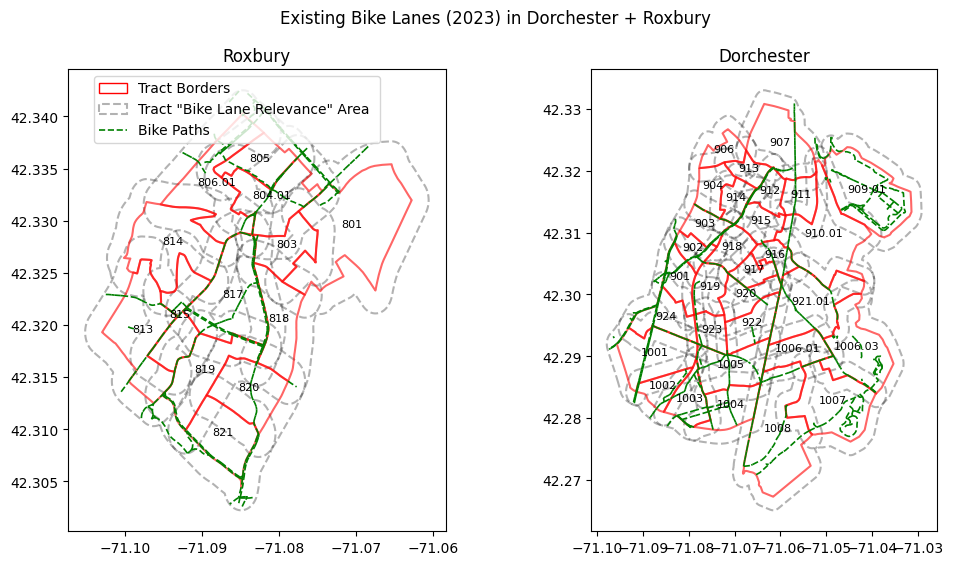

In [70]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create a new figure and axis
fig, ax = plt.subplots(1,2, figsize = (12,6))
Roxbury_buffer = gpd.GeoDataFrame(Roxbury_tracts, geometry='buffered_geometry')
Roxbury_buffer['buffered_geometry'].plot(ax=ax[0], color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')
Dorchester_buffer = gpd.GeoDataFrame(Dorchester_tracts, geometry='buffered_geometry')
Dorchester_buffer['buffered_geometry'].plot(ax=ax[1], color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

# create a single polygon for all buffered tracts
Roxbury_all = Roxbury_buffer.unary_union
Dorchester_all = Dorchester_buffer.unary_union

Roxbury_poly = gpd.GeoDataFrame(Roxbury_tracts, geometry='geometry')
Dorchester_poly = gpd.GeoDataFrame(Dorchester_tracts, geometry='geometry')

Roxbury_poly['geometry'].plot(ax=ax[0], color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")
Dorchester_poly['geometry'].plot(ax=ax[1], color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")
# Add labels to the centers of the polygons
for x, y, label in zip(Roxbury_poly.geometry.centroid.x, Roxbury_poly.geometry.centroid.y, Roxbury_poly['NAME10']):
    ax[0].text(x, y, label, fontsize=8, ha='center')
for x, y, label in zip(Dorchester_poly.geometry.centroid.x, Dorchester_poly.geometry.centroid.y, Dorchester_poly['NAME10']):
    ax[1].text(x, y, label, fontsize=8, ha='center')

# define bike lane geodf as all bike lanes within the buffered tracts
Roxbury_bike = bike_lanes[bike_lanes.geometry.within(Roxbury_all)]
Dorchester_bike = bike_lanes[bike_lanes.geometry.within(Dorchester_all)]
Roxbury_bike_lanes = gpd.GeoDataFrame(Roxbury_bike, geometry='geometry')
Dorchester_bike_lanes = gpd.GeoDataFrame(Dorchester_bike, geometry='geometry')
Roxbury_bike_lanes['geometry'].plot(ax=ax[0], color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")
Dorchester_bike_lanes['geometry'].plot(ax=ax[1], color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax[0].legend(handles=[Patch(facecolor='none', edgecolor='r', label='Tract Borders'),
                      Patch(facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label='Tract "Bike Lane Relevance" Area '),
                      Line2D([], [], color='g', linestyle='dashed', linewidth=1.2, label='Bike Paths')], loc='upper left', bbox_to_anchor=(0.05, 1))

ax[0].set_title('Roxbury')
ax[1].set_title('Dorchester')

plt.suptitle('Existing Bike Lanes (2023) in Dorchester + Roxbury')
plt.show()

Dorchester seems to have much more bike lanes area. Let's see if that is the case:

In [52]:
rox_dor_census_bike = census_bike[census_bike['neighborhood'].isin(['Roxbury', 'Dorchester'])]
rox_dor_census_bike.groupby('neighborhood')['total_built_all_lanes'].sum()

neighborhood
Dorchester    109698.680866
Roxbury        54413.906153
Name: total_built_all_lanes, dtype: float64

Doechester has ~X2 as many meters in new bike lanes (2010-2022). We should remember that the actual amount is lower, since many bike lanes are counted more than once, if they are inside multiple overlapping "buffered tracts". Let's see how this difference has developed over time:

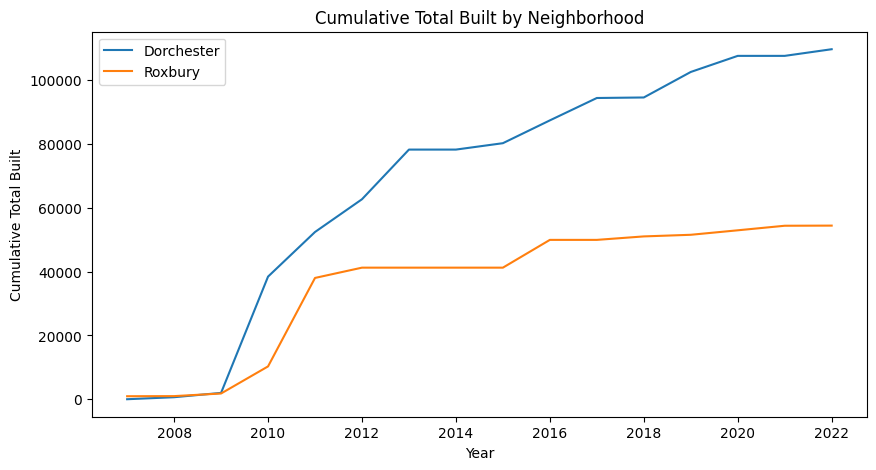

In [101]:
# plot cumulative total_built by neighborhood in census_bike across time
ax = rox_dor_census_bike.groupby(['year', 'neighborhood']).sum()['total_built_all_lanes'].unstack().cumsum().plot(figsize=(10,5))

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Total Built')
ax.set_title('Cumulative Total Built by Neighborhood')
ax.legend()
plt.show()


## Key Questions

In [95]:
correlation_matrix = rox_dor_census_bike[['median_income', 'total_built_all_lanes','race_white', 'median_age','percent_owners']].corr()
correlation_matrix

,median_income,total_built_all_lanes,race_white,median_age,percent_owners
median_income,1.000000,-0.143161,0.622001,0.553254,0.749734
total_built_all_lanes,-0.143161,1.000000,-0.062603,-0.114356,-0.061622
race_white,0.622001,-0.062603,1.000000,0.229069,0.420781
median_age,0.553254,-0.114356,0.229069,1.000000,0.648360
percent_owners,0.749734,-0.061622,0.420781,0.648360,1.000000


In the correlation matrix we can see that different socio-economic variables are highly correlated: areas with higher percentage of white population also have higher income, median age, and home owners. Regarding bike lanes, we can see that on average, they tend to be built in areas that have lower income, younger population, less home owners and less white population. This is a simple correlational observation, and we will look closer into this relationship in the regression analysis.
Next, we can look specificly within each neighborhood to see if these patterns are similar across different areas.

In [94]:
neighborhood_matrix = rox_dor_census_bike.groupby('neighborhood')[['median_income', 'total_built_all_lanes','race_white', 'median_age','percent_owners']].corr()
neighborhood_matrix

median_income  total_built_all_lanes  \
neighborhood                                                               
Dorchester   median_income               1.000000              -0.167322   
             total_built_all_lanes      -0.167322               1.000000   
             race_white                  0.699330              -0.044541   
             median_age                  0.627382              -0.121787   
             percent_owners              0.714656              -0.058356   
Roxbury      median_income               1.000000              -0.059896   
             total_built_all_lanes      -0.059896               1.000000   
             race_white                 -0.062697              -0.114743   
             median_age                  0.445860              -0.090897   
             percent_owners              0.693153              -0.028014   

                                    race_white  median_age  percent_owners  
neighborhood                                                                
Dorchester   median_income            0.699330    0.627382        0.714656  
             total_built_all_lanes   -0.044541   -0.121787       -0.058356  
             race_white               1.000000    0.435755        0.504297  
             median_age               0.435755    1.000000        0.718286  
             percent_owners           0.504297    0.718286        1.000000  
Roxbury      median_income           -0.062697    0.445860        0.693153  
             total_built_all_lanes   -0.114743   -0.090897       -0.028014  
             race_white               1.000000   -0.628374       -0.176024  
             median_age              -0.628374    1.000000        0.519892  
             percent_owners          -0.176024    0.519892        1.000000

We see similar patterns in both neighborohhods, but with some key differences: in both neighborhoods, new bike lanes are added to tracts, with lower income, lower median age, and lower percentages of whites and of home owners, on average. However, the magnitudes of these correlations is different: while in Dorchester the main negative relationship is between bike lanes and income, in Roxbury it is between bike lanes and percentage of whites. This difference can be partially explained by the differences in the neighborhoods: Dorchester shows a much stronger correlation between income and race, or income anbd age, than Roxbury; additionally, in Roxbury, the relationship between age & race is positive (higher % of white residents is associated with younger population) while Dorchester has it in the opposite direction. This can suggest that lower socio-demografic features tend to converge more strongly in Dorchester, and are more evenly spread in Roxbury. 

## Scope Refinement and Limitations

Our project faces some challenges that are important to keep in mind. 
* Scope Constraints:
Adhering to customer specifications and time constraints, our primary analysis is confined to two specific neighborhoods in Boston—Roxbury and Dorchester. While these areas may serve as reasonable proxies for socio-demographic characteristics in other Boston neighborhoods, it's important to acknowledge that the statistical robustness of our analysis is limited due to the inclusion of only two neighborhoods.
* Generalization Limitations:
Beyond the challenge of a limited geographical focus, our ability to generalize findings to broader regions is constrained. The utilization of bike lane data specific to Boston introduces variations in quality, maintenance, and other factors that may significantly differ from those in other locations. Disparities in road infrastructure, traffic conditions, and alternative transportation options across cities further emphasize the need to restrict the applicability of our analysis solely to the Boston area.
* Identification Challenges:
The core objective involves identifying a causal relationship between new bike lanes and socio-demographic shifts. However, both the introduction of bike lanes and changes in socio-demographic variables occur simultaneously over our data's time range, posing a challenge in establishing causality. Although we will use Diff-in-Diff methods to address this issue, it's important to acknowledge that complete elimination of reverse causality or other exogenous variables may not be achievable.
* Time Horizon Limitations:
The relatively short time span of our study further complicates our ability to precisely isolate the impact of new infrastructure over time. Factors such as non-linear effects and the duration of influence introduce complexities. To mitigate these challenges, we will make assumptions about a fixed timeframe for the effects to manifest and concentrate our analysis within these defined periods.

In light of these challenges, it is imperative that we approach our analysis with a nuanced understanding of its limitations and communicate findings with a clear awareness of the contextual constraints inherent in the study design.
